In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
####################################################################################################
# pre-process

original_csv_links = [
    "/Users/maslychm/projects/vr_selection/Assets/StreamingAssets/density_data/sr_sub2_1665156140.csv",
    "/Users/maslychm/projects/vr_selection/Assets/StreamingAssets/density_data/sr_sub3_1665169118.csv",
    "/Users/maslychm/projects/vr_selection/Assets/StreamingAssets/density_data/sr_sub4_1665171433.csv",
    "/Users/maslychm/projects/vr_selection/Assets/StreamingAssets/density_data/sr_sub5_1665177450.csv",
    "/Users/maslychm/projects/vr_selection/Assets/StreamingAssets/density_data/sr_sub6_1665181701.csv",
]

csv_root = "/Users/maslychm/projects/vr_selection/density_data/"
processed_csv_links = []
for link in original_csv_links:
    df = pd.read_csv(link)
    df["global_trial_idx"] = pd.Series(range(1, 121))
    
    sub_idx = link.split("sub")[-1][0]
    processed_csv_link = csv_root + "sub_" + sub_idx + ".csv"
    df.to_csv(processed_csv_link, index=False)
    processed_csv_links.append(processed_csv_link)

####################################################################################################
# load data

dataframes = [pd.read_csv(link) for link in processed_csv_links]
dfs = pd.concat(dataframes)

# drop rows where trial_time is over 20
dfs = dfs[dfs["trial_time"] < 20]

# pre-process global trial index: mod global_trial_idx by 31
dfs["global_trial_idx"] = dfs["global_trial_idx"] % 31

print(f"Number of rows: {len(dfs)}")


Number of rows: 577


In [3]:
dfs.groupby(
    [
        "subject_id", 
        "technique",
        "trial_type"
    ]
)[[
    "trial_time", 
    "num_attempts"
]].mean()

pass

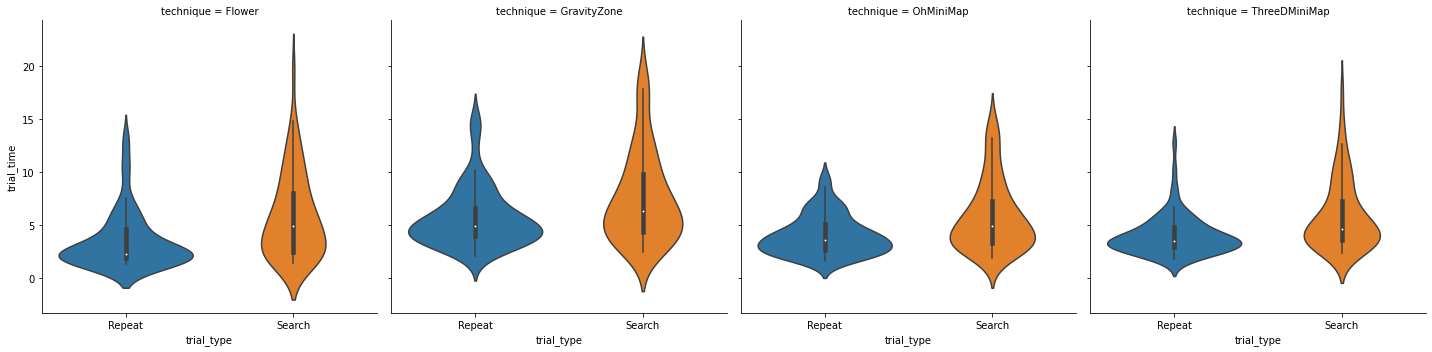

In [4]:
ax = sns.catplot(data=dfs, x="trial_type", y="trial_time", col="technique", kind="violin", showfliers=False)

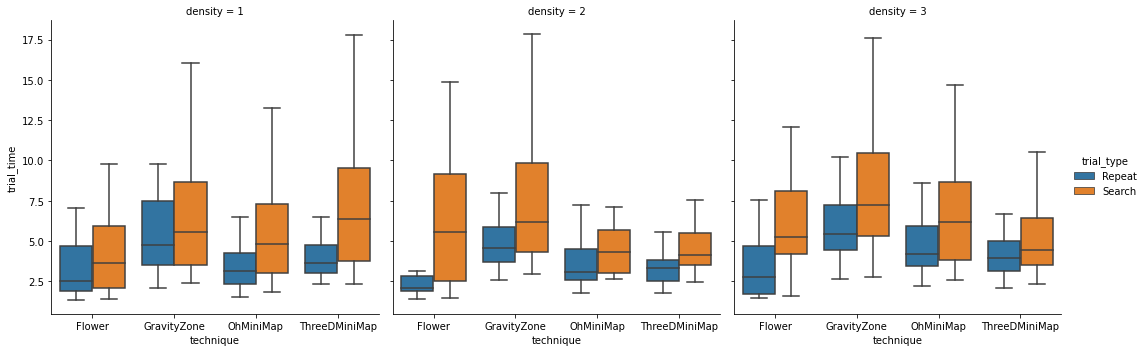

In [15]:
ax = sns.catplot(data=dfs, hue="trial_type", x="technique", y="trial_time", col="density", kind="box", showfliers=False)

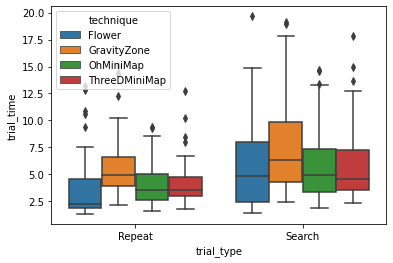

In [10]:
ax = sns.boxplot(data=dfs, x="trial_type", y="trial_time", hue="technique")

# ax = sns.violinplot(data=dfs, x="trial_type", y="trial_time", hue="technique")

In [38]:
# ax = sns.histplot(data=dfs, x="trial_time", hue="trial_type", multiple="stack", bins=100)

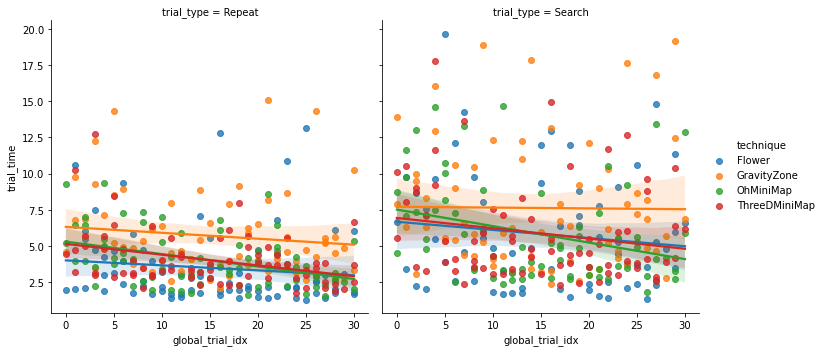

In [7]:
# distance to object to trial time
# ax = sns.lmplot(x="distance_to_obj", y="trial_time", data=dfs, hue="technique")

# split by trial type
# ax = sns.lmplot(x="distance_to_obj", y="trial_time", data=dfs, hue="technique", col="trial_type")

ax = sns.lmplot(x="global_trial_idx", y="trial_time", data=dfs, col="trial_type", hue="technique")

In [ ]:
dfs.groupby(["technique", "trial_type"])[[
    "trial_time", 
    "num_attempts",
    # "left_hand_distance_travelled", 
    # "right_hand_distance_travelled"
]].mean()

In [ ]:
dfs.columns.unique()

In [ ]:
cleandf = dfs[dfs["trial_time"] < 30]

In [ ]:
# sns.histplot(data=cleandf, x="trial_time", hue="trial_type", multiple="stack", bins=20)

In [ ]:
grouped_means = dfs.groupby(
    [
        "subject_id",
        "technique",
        "trial_type"
    ]
)[[
    "trial_time",
    "num_attempts",
    "technique",
    "trial_type",
    # "left_hand_distance_travelled",
    # "right_hand_distance_travelled"
]].mean()

print(len(grouped_means))

In [ ]:
for subject in dfs.subject_id.unique():
    print(subject)
    sdfs = dfs[dfs["subject_id"] == subject]

    for technique in sdfs.technique.unique():
        print(technique)
        tdfs = sdfs[sdfs["technique"] == technique]

        for trial_type in tdfs.trial_type.unique():
            print(trial_type)
            print(tdfs[tdfs["trial_type"] == trial_type]["trial_time"].mean())

In [33]:
dfs.global_trial_idx.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,  1,  0])

In [ ]:
dfs["global_trial_idx"] = dfs["global_trial_idx"] % 31

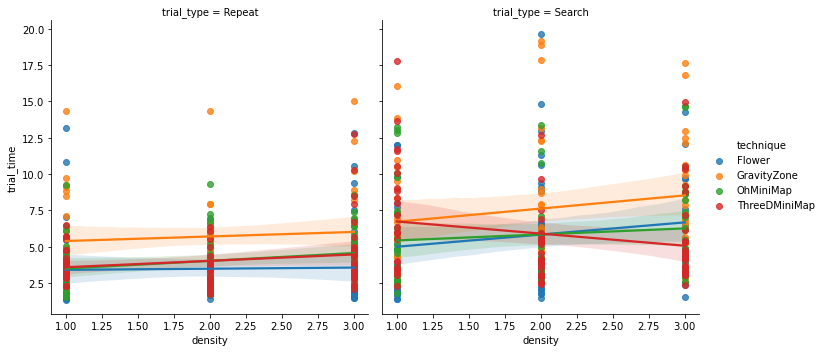

In [23]:
ax = sns.lmplot(data=dfs, x="density", y="trial_time", hue="technique", col="trial_type")